In [0]:
!pip install pyspark


     |▍   

*** WARNING: max output size exceeded, skipping output. ***

     |████████████████████████████████| 316.9 MB 3.8 kB/s 
     |████████████████████████████████| 200 kB 39.1 MB/s 
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425366 sha256=8afa2a9f480f649647ea4bc3564b3afb4bd13c89966cd82a845d5c7114bd6c34
  Stored in directory: /root/.cache/pip/wheels/57/bd/14/ce9e21f2649298678d011fb8f71ed38ee70b42b94fef0be142
Successfully built pyspark
You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-c654805c-899a-40df-802a-82d2742001aa/bin/python -m pip install --upgrade pip' command.


## Importing Libraries

In [0]:
# Python
import pandas as pd
import numpy as np
import time
import copy

# Scipy
from scipy import linalg

# Pyspark
from pyspark.mllib.linalg import Matrices
from pyspark.mllib.linalg.distributed import BlockMatrix
from pyspark.mllib.linalg.distributed import DenseMatrix

## Creating Input

### Reference
https://spark.apache.org/docs/latest/mllib-data-types.html#distributed-matrix

In [0]:
# Set the size of your input data
size = 512

In [0]:
# Set the datatype of your input
data_type = 'float32'

In [0]:
# Assuming numpy array as input
start_time = time.time()
input_arr = np.random.rand(size, size).astype(data_type) 
print("--- %s seconds ---" % (time.time() - start_time))

print("Shape of input array is: " + str(input_arr.shape))

--- 0.0029060840606689453 seconds ---
Shape of input array is: (512, 512)


In [0]:
# Check the size of input array
from sys import getsizeof
print("Size of input array in GB is: " + str(getsizeof(input_arr)/1e9))

Size of input array in GB is: 0.001048696


### Standard matrix inversion function


In [0]:

def invertMatrix(matrix):

    matrixCopy = copy.deepcopy(matrix)

    numRows = matrixCopy.shape[0]
    numCols = matrixCopy.shape[1]

    identityMatrix = []

    for i in range(numRows):
        row = []
        for j in range(numCols):
            if i == j:
                row.append(1)
            else:
                row.append(0)
        identityMatrix.append(row)

    identityMatrix = np.array(identityMatrix)


    augmentedMatrix = []

    for i in range(numRows):
        row = []
        for j in range(numCols):
            row.append(matrixCopy[i][j])
        for j in range(numCols):
            row.append(identityMatrix[i][j])
        augmentedMatrix.append(row)

    augmentedMatrix = np.array(augmentedMatrix)

    for i in range(numRows):

        divisor = augmentedMatrix[i][i]
        for j in range(2*numCols):
            augmentedMatrix[i][j] /= divisor


        for j in range(numRows):
            if i != j:
                multiple = augmentedMatrix[j][i]
                for k in range(2*numCols):
                    augmentedMatrix[j][k] -= multiple * augmentedMatrix[i][k]

    inverseMatrix = []

    for i in range(numRows):
        row = []
        for j in range(numCols, 2*numCols):
            row.append(augmentedMatrix[i][j])
        inverseMatrix.append(row)

    inverseMatrix = np.array(inverseMatrix)

    return inverseMatrix

### Time calculation using standard matrix inversion

In [0]:
# Assuming numpy array as input
start_time = time.time()
print(input_arr.shape)
input_inverse = invertMatrix(input_arr) 
print("--- %s seconds ---" % (time.time() - start_time))

print("Inverse is:")
print(input_inverse)

(512, 512)
--- 225.9223508834839 seconds ---
Inverse is:
[[-0.21676366 -0.71666031  0.56622849 ...  0.62032288 -0.21128916
   0.92705021]
 [ 0.17109804 -0.02461913 -0.14922439 ... -0.19148107  0.13780718
   0.08564419]
 [ 0.03085085 -0.08351774  0.30262095 ...  0.20213909 -0.18988718
   0.31336104]
 ...
 [-0.02244999 -0.22055929  0.19919572 ... -0.15433544  0.12890604
   0.31845363]
 [-0.10339808 -1.14369205  1.05468785 ...  0.38383402  0.33883209
   1.88997495]
 [-0.15759242  0.08405776 -0.05934851 ...  0.19375007 -0.3698337
  -0.24165341]]


### RDD of sub-matrix blocks

In [0]:
# Define block size
block_size = 128

In [0]:
def makeBlocks(arr, nrows, ncols):
    '''
    Return an array of shape (n, nrows, ncols) where 
    n * nrows * ncols = arr.size

    '''

    h, w = arr.shape
    assert h % nrows == 0, "{} rows is not evenly divisible by {}".format(h, nrows)
    assert w % ncols == 0, "{} cols is not evenly divisible by {}".format(w, cols)

    return (arr.reshape(h//nrows, nrows, -1, ncols)
          .swapaxes(1, 2)
          .reshape(-1, nrows, ncols))

In [0]:
block_arrays = makeBlocks(input_arr, block_size, block_size)
print("Shape of Blocked Array is: {}".format(block_arrays.shape))
print("Blocked Array is: {}".format(block_arrays))

Shape of Blocked Array is: (16, 128, 128)
Blocked Array is: [[[0.06856065 0.7049935  0.7947288  ... 0.32049268 0.762585   0.902201  ]
  [0.77222353 0.526277   0.9122474  ... 0.9416174  0.14682837 0.6963715 ]
  [0.5247899  0.6939789  0.496976   ... 0.854901   0.9688924  0.9928149 ]
  ...
  [0.46322724 0.2972216  0.0964097  ... 0.21983248 0.20889117 0.8923598 ]
  [0.0811732  0.012419   0.02184878 ... 0.15527895 0.28374562 0.80215526]
  [0.650372   0.3782095  0.8307698  ... 0.82945174 0.41528296 0.7731347 ]]

 [[0.6784819  0.40295282 0.96300626 ... 0.85392964 0.4170406  0.40505528]
  [0.48759317 0.8843036  0.6340013  ... 0.73117715 0.28263727 0.3141004 ]
  [0.23401524 0.57183456 0.59928215 ... 0.89106417 0.9967874  0.53937626]
  ...
  [0.5416865  0.64996487 0.51871413 ... 0.5950696  0.91161644 0.01207403]
  [0.9422436  0.7317141  0.5121099  ... 0.5940127  0.6850341  0.00959634]
  [0.28489745 0.6249339  0.43877944 ... 0.08503819 0.29865795 0.5133013 ]]

 [[0.3367813  0.55228364 0.46720517 

In [0]:
block_arrays_list = []
num_blocks = block_arrays.shape[0]
num_rowIndex = input_arr.shape[0]//block_size
for idx in range(num_blocks):
    block  = ((idx//num_rowIndex, idx%num_rowIndex), Matrices.dense(block_size, block_size, block_arrays[idx].flatten(order='F')))
    block_arrays_list.append(block)

In [0]:
print("Blocked Array List is: {}".format(block_arrays_list))

Blocked Array List is: [((0, 0), DenseMatrix(128, 128, [0.0686, 0.7722, 0.5248, 0.0305, 0.3984, 0.4677, 0.6899, 0.4571, ..., 0.8987, 0.4247, 0.4817, 0.7528, 0.4244, 0.8924, 0.8022, 0.7731], False)), ((0, 1), DenseMatrix(128, 128, [0.6785, 0.4876, 0.234, 0.2605, 0.3527, 0.7994, 0.7647, 0.0618, ..., 0.7706, 0.2211, 0.5442, 0.3501, 0.0545, 0.0121, 0.0096, 0.5133], False)), ((0, 2), DenseMatrix(128, 128, [0.3368, 0.6715, 0.2195, 0.7114, 0.4203, 0.4162, 0.2047, 0.4821, ..., 0.9937, 0.5441, 0.7342, 0.8067, 0.9812, 0.4777, 0.846, 0.0666], False)), ((0, 3), DenseMatrix(128, 128, [0.2965, 0.0493, 0.3388, 0.6591, 0.4647, 0.6356, 0.4505, 0.3463, ..., 0.0945, 0.1508, 0.9339, 0.2995, 0.2885, 0.2606, 0.8394, 0.1406], False)), ((1, 0), DenseMatrix(128, 128, [0.0081, 0.9644, 0.4749, 0.3708, 0.3338, 0.356, 0.4335, 0.0665, ..., 0.8061, 0.7326, 0.5417, 0.9104, 0.5119, 0.0427, 0.3677, 0.2772], False)), ((1, 1), DenseMatrix(128, 128, [0.1435, 0.4597, 0.9403, 0.3492, 0.7071, 0.1228, 0.2455, 0.3357, ..., 0.8

In [0]:
# Parallelize the Block Array List
blocks = sc.parallelize(block_arrays_list)

# Type will be .rdd
print("Type of blocks is: {}".format(type(blocks)))

Type of blocks is: <class 'pyspark.rdd.RDD'>


### Create BlockMatrix 

In [0]:
# Assuming numpy array as input
start_time = time.time()
A = BlockMatrix(blocks, block_size, block_size) 
print("--- %s seconds ---" % (time.time() - start_time))
print("Created BlockMatrix from RDD of sub-matrix blocks")

--- 14.316915273666382 seconds ---
Created BlockMatrix from RDD of sub-matrix blocks


In [0]:
print("Number of rows of BlockMatrix: {}".format(A.numRows()))
print("Number of columns of BlockMatrix: {}".format(A.numCols()))

Number of rows of BlockMatrix: 512
Number of columns of BlockMatrix: 512


In [0]:
# Validate the BlockMatrix
A.validate()

In [0]:
# Print the first element of BlockRDD
print("First element of Block RDD is: {}".format(A.blocks.first()))

First element of Block RDD is: ((0, 0), DenseMatrix(128, 128, [0.0686, 0.7722, 0.5248, 0.0305, 0.3984, 0.4677, 0.6899, 0.4571, ..., 0.8987, 0.4247, 0.4817, 0.7528, 0.4244, 0.8924, 0.8022, 0.7731], 0))


## Inverse using Strassen's Matrix Inverse Algorithm

### MapToPair()

In [0]:
def MapToPair(block, size):
    ri = block[0][0]
    ci = block[0][1]

    if (ri//size == 0) and (ci//size == 0):
        tag = "A11"
    elif (ri//size == 0) and (ci//size == 1):
        tag = "A12"
    elif (ri//size == 1) and (ci//size == 0):
        tag = "A21"
    elif (ri//size == 1) and (ci//size == 1):
        tag = "A22"

    # Get the number of rows, number of columns and values to create a new block
    numRows = block[1].numRows
    numCols = block[1].numCols
    matrixValues = block[1].values

    # Row Index and Column Index of the new block
    rowIndex = ri % size
    colIndex = ci % size

    newBlock = ((rowIndex, colIndex), Matrices.dense(numRows, numCols, matrixValues))

    return (tag, newBlock)  

### breakMat()

In [0]:
def breakMat(A, size):
    ARDD = A.blocks
    return ARDD.map(lambda x: MapToPair(x, size))

### xy()

In [0]:
def function_xy(x, y, pairRDD, block_size):
    tag = 'A' + x + y
    filteredRDD = pairRDD.filter(lambda x: x[0] == tag)
    blocks = filteredRDD.map(lambda x: x[1])
    return BlockMatrix(blocks, block_size, block_size)

### scipy inverse()

In [0]:
def scipy_inverse(block):
    # Get the Row Index and Column Index of the block
    rowIndex = block[0][0]
    colIndex = block[0][1]

    # Get values to find the inverse
    matrixValues = block[1].toArray()

    # Find inverse using scipy
    inverse_matrixValues = linalg.inv(matrixValues)

    # Change the inverse matrix to column major order
    inverse_matrixValues = inverse_matrixValues.flatten(order='F')

    inverse_block = ((rowIndex, colIndex), Matrices.dense(block[1].numRows, block[1].numCols, inverse_matrixValues))

    return inverse_block

### multiply()

In [0]:
def multiply(mat1, mat2):
    mat1_mat2 = mat1.multiply(mat2)
    return mat1_mat2

### subtract()

In [0]:
def subtract(mat1, mat2):
    mat1_mat2 = mat1.subtract(mat2)
    return mat1_mat2

### Scalar Multiplication

In [0]:
def scalarMulHelper(block, scalar):
    # Get the RowIndex and the ColIndex of the block
    rowIndex = block[0][0]
    colIndex = block[0][1]

    # Get values to multiply with a scalar
    matrixValues = block[1].values
    matrixValues = matrixValues*scalar

    newBlock = ((rowIndex, colIndex), Matrices.dense(block[1].numRows, block[1].numCols, matrixValues))

    return newBlock

In [0]:
def scalarMul(A, scalar, block_size):
    ARDD = A.blocks
    blocks = ARDD.map(lambda x: scalarMulHelper(x, scalar))
    return BlockMatrix(blocks, block_size, block_size)

### arrange()

In [0]:
def map_c12(block, size):
    # Get the RowIndex and the ColIndex of the block
    rowIndex = block[0][0]
    colIndex = block[0][1]
    colIndex = colIndex + size
    return ((rowIndex, colIndex), Matrices.dense(block[1].numRows, block[1].numCols, block[1].values))

def map_c21(block, size):
    # Get the RowIndex and the ColIndex of the block
    rowIndex = block[0][0]
    rowIndex = rowIndex + size
    colIndex = block[0][1]
    return ((rowIndex, colIndex), Matrices.dense(block[1].numRows, block[1].numCols, block[1].values))

def map_c22(block, size):
    # Get the RowIndex and the ColIndex of the block
    rowIndex = block[0][0]
    rowIndex = rowIndex + size
    colIndex = block[0][1]
    colIndex = colIndex + size
    return ((rowIndex, colIndex), Matrices.dense(block[1].numRows, block[1].numCols, block[1].values))

In [0]:
def arrange(C11, C12, C21, C22, size, block_size):
    C11RDD = C11.blocks
    C12RDD = C12.blocks
    C21RDD = C21.blocks
    C22RDD = C22.blocks

    C1 = C12RDD.map(lambda x: map_c12(x, size//block_size))
    C2 = C21RDD.map(lambda x: map_c21(x, size//block_size))
    C3 = C22RDD.map(lambda x: map_c22(x, size//block_size))

    unionRDD = C11RDD.union(C1.union(C2.union(C3)))

    return BlockMatrix(unionRDD, block_size, block_size)

### inverse()

In [0]:
def inverse(A, size, block_size):
    n = size//block_size
    if n == 1:
        A_RDD = A.blocks
        A_Inverse_Block = A_RDD.map(lambda x: scipy_inverse(x))
        return BlockMatrix(A_Inverse_Block, block_size, block_size)
    else:
        size = size/2
        pairRDD = breakMat(A, size//block_size)
        A11 = function_xy(str(1), str(1), pairRDD, block_size)
        A12 = function_xy(str(1), str(2), pairRDD, block_size)
        A21 = function_xy(str(2), str(1), pairRDD, block_size)
        A22 = function_xy(str(2), str(2), pairRDD, block_size)
        one = inverse(A11, size, block_size)
        two = multiply(A21, one)
        three = multiply(one, A12)
        four = multiply(A21, three)
        five = subtract(four, A22)
        six = inverse(five, size, block_size)
        C12 = multiply(three, six)
        C21 = multiply(six, two)
        seven = multiply(three, C21)
        C11 = subtract(one, seven)
        C22 = scalarMul(six, -1, block_size)
        C = arrange(C11, C12, C21, C22, size, block_size)
        return C

In [0]:
start_time = time.time()
A_inv = inverse(A, size, block_size)
print("--- %s seconds ---" % (time.time() - start_time))

--- 82.80237674713135 seconds ---


## Test Strassen's Matrix Inverse implementation with standard inverse algorithm

In [0]:
inverse_standard = np.around(input_inverse, decimals = 6)
inverse_strassen = np.around(A_inv.toLocalMatrix().toArray(), decimals = 6)

print(np.allclose(inverse_standard, inverse_strassen, atol=1e-3))


True


### Compare Strassen's algorith with standard algorith for different matrix sizes

In [0]:
matrix_sizes = [128, 256, 512, 1024]

time_normal = []
time_strassen = []

for size in matrix_sizes:
    # Assuming numpy array as input
    start_time = time.time()
    input_arr = np.random.rand(size, size).astype(data_type) 
    input_inverse = invertMatrix(input_arr) 
    time_normal.append(time.time() - start_time)

    # Assuming numpy array as input
    start_time = time.time()
    block_arrays = makeBlocks(input_arr, block_size, block_size)
    block_arrays_list = []
    num_blocks = block_arrays.shape[0]
    num_rowIndex = input_arr.shape[0]//block_size
    for idx in range(num_blocks):
        block  = ((idx//num_rowIndex, idx%num_rowIndex), Matrices.dense(block_size, block_size, block_arrays[idx].flatten(order='F')))
        block_arrays_list.append(block)

    # Parallelize the Block Array List
    blocks = sc.parallelize(block_arrays_list)

    # Type will be .rdd
    A = BlockMatrix(blocks, block_size, block_size) 
    A_inv = inverse(A, size, block_size)
    time_strassen.append(time.time() - start_time)
    
print(time_normal)
print(time_strassen)


[3.189861536026001, 26.946996450424194, 218.62466669082642, 1828.4930114746094]
[3.467665910720825, 24.813191413879395, 71.99930477142334, 257.6307384967804]


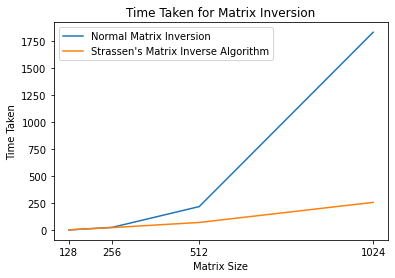

In [0]:
import matplotlib.pyplot as plt

plt.plot(matrix_sizes, time_normal, label = "Normal Matrix Inversion")
plt.plot(matrix_sizes, time_strassen, label = "Strassen's Matrix Inverse Algorithm")

plt.xlabel('Matrix Size')
plt.ylabel('Time Taken')
plt.title('Time Taken for Matrix Inversion')
plt.xticks(matrix_sizes)
plt.legend()
plt.show()

